# Import Utils

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Loading Data & Preprocessing

In [2]:
#loading data
train = pd.read_table('/content/drive/MyDrive/NLP/train.tsv')
test = pd.read_table('/content/drive/MyDrive/NLP/test.tsv')
sub = pd.read_csv('/content/drive/MyDrive/NLP/sampleSubmission.csv')

In [3]:
def preprocess(text):
  stopwords = nltk.corpus.stopwords.words('english')  
  tokens = nltk.word_tokenize(text) 
  lower = [word.lower() for word in tokens]                                   #tokens lowercase
  no_stopwords = [word for word in lower if word not in stopwords]            #removing stopwords
  no_alpha = [word for word in no_stopwords if word.isalpha()]                #taking every (and only) alphanumerical chars
  lemm_text = [nltk.WordNetLemmatizer().lemmatize(word, pos='n') for word in no_alpha] #"n"nouns,"v" verbs, "a" adjectives, "r" adverbs, "s" satellite adjectives ("arid"="dry"+context)
  lemm_text = [nltk.WordNetLemmatizer().lemmatize(word, pos='v') for word in lemm_text]
  lemm_text = [nltk.WordNetLemmatizer().lemmatize(word, pos='r') for word in lemm_text]
  lemm_text = [nltk.WordNetLemmatizer().lemmatize(word, pos='s') for word in lemm_text]
  lemm_text = [nltk.WordNetLemmatizer().lemmatize(word, pos='a') for word in lemm_text] #lemmatizing final result

  return lemm_text

#mapping previous func to every phrase of train and test then joining words to obtain lemmatized train and test
train['pre_processing'] = train['Phrase'].map(preprocess) 
train['lemm_text'] = train['pre_processing'].apply(lambda x: " ".join([str(word) for word in x]))

test['pre_processing'] = test['Phrase'].map(preprocess)
test['lemm_text']=test['pre_processing'].apply(lambda x: " ".join([str(word) for word in x]))

train

,PhraseId,SentenceId,Phrase,Sentiment,pre_processing,lemm_text
0,1,1,A series of escapades demonstrating the adage ...,1,"[series, escapade, demonstrate, adage, good, g...",series escapade demonstrate adage good goose a...
1,2,1,A series of escapades demonstrating the adage ...,2,"[series, escapade, demonstrate, adage, good, g...",series escapade demonstrate adage good goose
2,3,1,A series,2,[series],series
3,4,1,A,2,[],
4,5,1,series,2,[series],series
...,...,...,...,...,...,...
156055,156056,8544,Hearst 's,2,[hearst],hearst
156056,156057,8544,forced avuncular chortles,1,"[force, avuncular, chortle]",force avuncular chortle
156057,156058,8544,avuncular chortles,3,"[avuncular, chortle]",avuncular chortle
156058,156059,8544,avuncular,2,[avuncular],avuncular


In [ ]:
test

,PhraseId,SentenceId,Phrase,pre_processing,lemm_text
0,156061,8545,An intermittently pleasing but mostly routine ...,"[intermittently, please, mostly, routine, effort]",intermittently please mostly routine effort
1,156062,8545,An intermittently pleasing but mostly routine ...,"[intermittently, please, mostly, routine, effort]",intermittently please mostly routine effort
2,156063,8545,An,[],
3,156064,8545,intermittently pleasing but mostly routine effort,"[intermittently, please, mostly, routine, effort]",intermittently please mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine,"[intermittently, please, mostly, routine]",intermittently please mostly routine
...,...,...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario .","[predictable, scenario]",predictable scenario
66288,222349,11855,"A long-winded , predictable scenario","[predictable, scenario]",predictable scenario
66289,222350,11855,"A long-winded ,",[],
66290,222351,11855,A long-winded,[],


# Attempt 1 - Logistic Regression

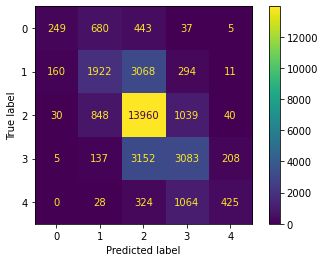

              precision    recall  f1-score   support

           0       0.56      0.18      0.27      1414
           1       0.53      0.35      0.42      5455
           2       0.67      0.88      0.76     15917
           3       0.56      0.47      0.51      6585
           4       0.62      0.23      0.34      1841

    accuracy                           0.63     31212
   macro avg       0.59      0.42      0.46     31212
weighted avg       0.61      0.63      0.60     31212

Accuracy: 62.921%


In [10]:
train_x, val_x, train_y, val_y  = train_test_split(train['Phrase'], train['Sentiment'], test_size=0.2, stratify=train['Sentiment'],random_state=42) #splitting train set (80%train 20%validation) \\ train['Phrase']= input features - train['sentiment']= label vector of input data
                                                                                                                                                    #stratify tells the method to maintain the class-labels proportions of input data in new split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer(tokenizer=preprocess) #gives us the td-idf features for the log_reg

logistic_reg_model = Pipeline([("vectorizer", vectorizer),                          #generating matrix of TF-IDF features
                               ("classifier", LogisticRegression(solver='saga'))])  #choosing the classifier ('saga' for large dataset and multiclass problems)
logistic_reg_model.fit(train_x,train_y)                                             #training the model
logistic_reg_prediction = logistic_reg_model.predict(val_x)                         #prediction on validation set (train)

conf_matrix=confusion_matrix(val_y, logistic_reg_prediction)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0, 1, 2, 3, 4])
conf_matrix_display.plot()
plt.show()

print(classification_report(val_y, logistic_reg_prediction))
print(f'Accuracy: {round(accuracy_score(val_y, logistic_reg_prediction)*100, 3)}%')

In [ ]:
#submitting test results to .csv
logistic_reg_prediction = logistic_reg_model.predict(test.lemm_text) #prediction on test set

sub = pd.DataFrame(list(zip(test.PhraseId, logistic_reg_prediction)), #generating the dataframe iterating on phraseId and Sentiment 
                   columns =['PhraseId', 'Sentiment'])

sub.to_csv('/content/drive/MyDrive/NLP/log_reg_POLI.csv', index=False)

# Attempt 2 - Recurrent Neural Network


In [6]:
all_data = pd.concat([train, test]) #combininig data

from keras.preprocessing.text import Tokenizer
tk = Tokenizer()
tk.fit_on_texts(all_data['Phrase']) #updates internal vocabulary based on data phrases
all_text = tk.texts_to_sequences(all_data['Phrase']) #transforms each text in data phrases to a sequence of integers.

In [8]:
#padding data (in order to make all sequences fit the same length)
from keras.preprocessing.sequence import pad_sequences
all_pad = pad_sequences(all_text)     
padded_train = all_pad[:len(train)]
padded_test = all_pad[len(train):]

padded_train

array([[    0,     0,     0, ...,     3,     2,    42],
       [    0,     0,     0, ...,    13,     1,  3940],
       [    0,     0,     0, ...,     0,     2,   315],
       ...,
       [    0,     0,     0, ...,     0, 11171, 11172],
       [    0,     0,     0, ...,     0,     0, 11171],
       [    0,     0,     0, ...,     0,     0, 11172]], dtype=int32)

In [ ]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(padded_train, train['Sentiment'], test_size=0.2, random_state=42)

#generating the model
from keras.backend import dropout
from keras.models import Sequential
from keras.layers import *

model = Sequential()                                                #plain stack of layers
model.add(Embedding(len(tk.word_index)+1, 300, input_length = 52))    #convert each word into a fixed length vector of defined size. The resultant vector is a dense one with having real values (something like a look-up table: words become keys, dense words become values)
                                                                      # The model will take as input an integer matrix of size (batch, input_length) (none,52), 
                                                                      # and the largest integer in the input should be no larger than (vocabulary size).
                                                                      # Now model.output_shape is (None, 52, 300), where `None` is the batch dimension and 300 is the dense output embedding dimension
model.add(SimpleRNN(100))                                           #the recurrent layer (100= units, dimensionality of the output space) -> 2D tensor of shape (batch_size, 100)
model.add(Dense(50, activation = 'softmax'))                        #dot(input kernel), Softmax maps output to a [0,1] range, but also maps each output in such a way that the total sum is 1. (probability distribution) 
model.add(Dropout(0.3))                                             #helps prevent overfitting randomly setting input to 0 a frequenct 0.3
model.add(Dense(5, activation = 'softmax'))                         #(50=units, dimensionality of the output space)

model.compile(metrics = ['acc'], loss = 'sparse_categorical_crossentropy', optimizer ='adam') #categorical vs sparse_categorical -> format:categorical_crossentropy for problems like [1,0,0] , [0,1,0], [0,0,1]. sparse_categorical_crossentropy for problems like [1], [2], [3].
model.summary()                                                                               #adam= an algorithm for first-order gradient-based optimization, based on adaptive estimates of lower-order moments.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 52, 300)           5334300   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 255       
                                                                 
Total params: 5,379,705
Trainable params: 5,379,705
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#training the model and making prediction
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("new_model", save_best_only=True)


#batch size number of samples that will be propagated through the network. train on firs 512, train on second 512...
history = model.fit(train_x, train_y, epochs = 200, batch_size = 512, validation_data = (val_x, val_y), callbacks=[early_stopping, model_checkpoint])
result = model.predict(padded_test)

Epoch 1/200
244/244 [==============================] - 98s 397ms/step - loss: 1.4173 - acc: 0.5092 - val_loss: 1.3461 - val_acc: 0.5011
Epoch 2/200
244/244 [==============================] - 95s 388ms/step - loss: 1.3243 - acc: 0.5122 - val_loss: 1.2944 - val_acc: 0.5011
Epoch 3/200
244/244 [==============================] - 95s 389ms/step - loss: 1.2638 - acc: 0.5216 - val_loss: 1.1872 - val_acc: 0.5412
Epoch 4/200
244/244 [==============================] - 103s 424ms/step - loss: 1.1246 - acc: 0.5812 - val_loss: 1.0576 - val_acc: 0.6111
Epoch 5/200
244/244 [==============================] - 95s 388ms/step - loss: 1.0386 - acc: 0.6072 - val_loss: 0.9948 - val_acc: 0.6274
Epoch 6/200
244/244 [==============================] - 93s 381ms/step - loss: 0.9687 - acc: 0.6317 - val_loss: 0.9494 - val_acc: 0.6391
Epoch 7/200
244/244 [==============================] - 91s 374ms/step - loss: 0.9125 - acc: 0.6515 - val_loss: 0.9247 - val_acc: 0.6446
Epoch 8/200
244/244 [==========================

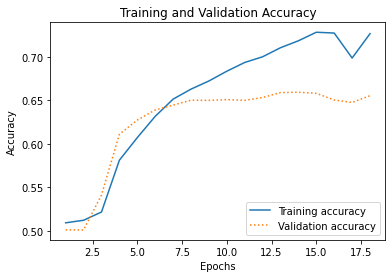

In [ ]:
#plotting results
model = tf.keras.models.load_model("new_model")

acc = history.history['acc']
val = history.history['val_acc']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
#submitting test results to .csv
sub['Sentiment'] = result.argmax(1)
sub.to_csv('/content/drive/MyDrive/NLP/RNN_POLI.csv', index=False)
sub

,PhraseId,Sentiment
0,156061,1
1,156062,1
2,156063,2
3,156064,1
4,156065,2
...,...,...
66287,222348,1
66288,222349,1
66289,222350,1
66290,222351,1


# Stats

['film', 'movie', 'one', 'good', 'story', 'make', 'funny', 'performance', 'character', 'work', 'comedy', 'like', 'best', 'love', 'life', 'time', 'way', 'great', 'enough', 'u', 'even', 'well', 'new', 'director', 'fun', 'much', 'look', 'heart', 'entertaining', 'humor', 'something', 'year', 'audience', 'little', 'drama', 'cast', 'world', 'moment', 'take', 'see', 'made', 'without', 'still', 'never', 'feel', 'actor', 'give', 'sense', 'real', 'also', 'interesting', 'people', 'thriller', 'often', 'family', 'human', 'compelling', 'worth', 'moving', 'picture', 'fascinating', 'come', 'tale', 'keep', 'many', 'get', 'two', 'laugh', 'action', 'may', 'right', 'piece', 'really', 'emotional', 'better', 'sweet', 'enjoyable', 'documentary', 'cinema', 'woman', 'find', 'thing', 'first', 'romantic', 'big', 'kind', 'powerful', 'ever', 'acting', 'visual', 'smart', 'beautiful', 'engaging', 'original', 'comic', 'watch', 'scene', 'could', 'power', 'star', 'music', 'screen', 'american', 'charming', 'solid', 'go'

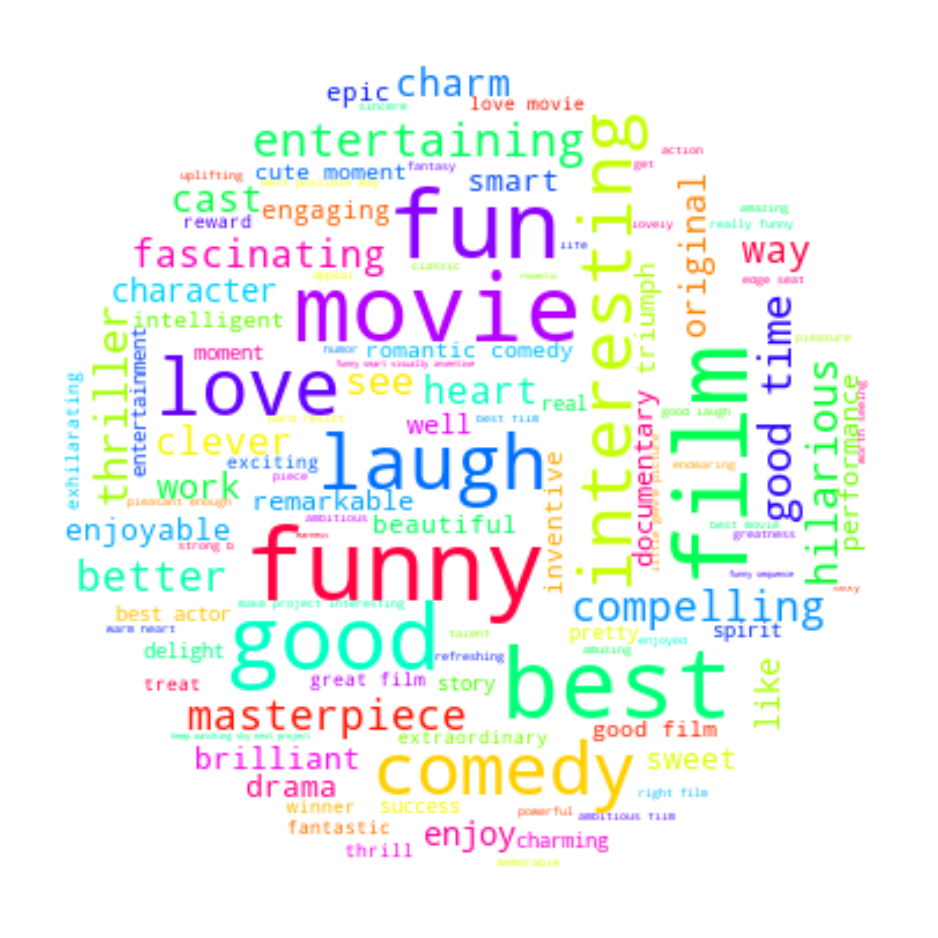

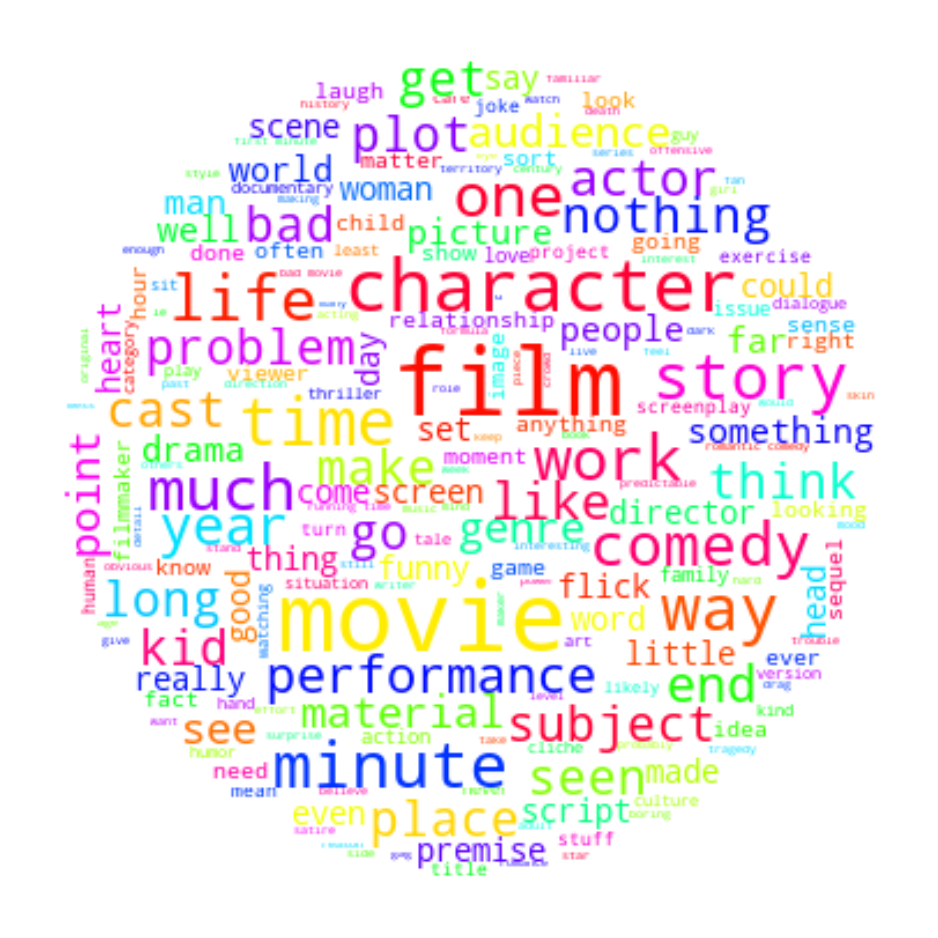

67.5 %


In [ ]:
#some stats and graphs
import math
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

pos_train=train
i = train[((train.Sentiment == 0 ))].index 
pos_train = pos_train.drop(i)
i = train[((train.Sentiment == 1))].index 
pos_train = pos_train.drop(i)
i = train[((train.Sentiment == 2))].index 
pos_train = pos_train.drop(i)

positive_words=Counter(" ".join(pos_train["lemm_text"]).split()).most_common(200)
pos_list = []
for couple in positive_words:
  pos_list.append(couple[0])
print(pos_list)


neg_train=train
i = train[((train.Sentiment == 3))].index 
neg_train = neg_train.drop(i)
i = train[((train.Sentiment == 4))].index 
neg_train = neg_train.drop(i)

negative_words=Counter(" ".join(neg_train["lemm_text"]).split()).most_common(200)
neg_list = []
for couple in negative_words:
  neg_list.append(couple[0])
print(neg_list)


pos_dictionary=Counter(pos_train["lemm_text"])
neg_dictionary=Counter(neg_train["lemm_text"])

x, y = np.ogrid[:400, :400]
mask = (x - 200) ** 2 + (y - 200) ** 2 > 180 ** 2
mask = 255 * mask.astype(int)

pos_cloud = WordCloud(max_font_size=80, colormap="hsv", mask=mask, background_color = "white").generate_from_frequencies(pos_dictionary)
plt.figure(figsize=(20,17))
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print("\n")

neg_cloud = WordCloud(max_font_size=80,colormap="hsv", mask=mask, background_color = "white").generate_from_frequencies(neg_dictionary)
plt.figure(figsize=(20,17))
plt.imshow(neg_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


pos_counter = Counter(pos_list)
neg_counter = Counter(neg_list)


def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

print(counter_cosine_similarity(pos_counter, neg_counter) * 100, "%")